In [1]:
%matplotlib inline
import pymysql as mdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# connect to mysql db
con = mdb.connect('localhost', 'root', '', 'RNAseq1') #host, user, password, #database

In [3]:
# connect to IDKey
with con:
    cur = con.cursor()
    cur.execute("SELECT * FROM IDKey;") # AMP-AD_ROSMAP_Rush-Broad_IDKey.csv
    rows = cur.fetchall()

# load IDKey
colnames = tuple([desc[0] for desc in cur.description])
idkey = pd.DataFrame(list(rows),columns=colnames)
idkey = idkey.set_index(idkey.projid)
idkey = idkey.drop(['projid', 'ind'], axis=1)

# get samples with methylation data
mwasids = idkey.loc[idkey['mwas_data']==1,'mwas_id']

420133 methylation marks have been assayed,
there are 3 ids for projid 82317494,
there are 10 ids for projid 21274866

In [4]:
mwas = pd.DataFrame.from_csv("71cpgs.data.csv") # 71 methylation marks selected from AMP-AD_ROSMAP_Rush-Broad_IlluminaHumanMethylation450_740_imputed.tsv
# mwas.head()

In [5]:
# map mwas ids to projids
tmp = dict(zip(idkey.mwas_id, idkey.index))
mwas = pd.DataFrame.rename(mwas,columns=tmp)
mwas.shape

(71, 740)

In [6]:
# connect to Clinical data
with con:
    cur = con.cursor()
    cur.execute("SELECT * FROM Clinical;")  # AMP-AD_ROSMAP_Rush-Broad_Clinical.csv
    rows = cur.fetchall()

# load Clinical data
colnames = tuple([desc[0] for desc in cur.description])
clin = pd.DataFrame(list(rows),columns=colnames)
clin = clin.set_index(clin.projid)
clin = clin.drop(['projid','ind'], axis=1)
#lin.head()

In [7]:
# print clinical variations in sorted order
mwasclin = clin[clin.index.isin(list(mwas.T.index))]

# remove samples with cogdx values 0,3,5,6
mwasclin = mwasclin.loc[mwasclin['cogdx'].isin([1,2,4])]
mwasclin = pd.DataFrame.sort_index(mwasclin)

In [8]:
# get samples with proper cogdx
mwas = mwas.T[mwas.T.index.isin(list(mwasclin.index))]
mwas = pd.DataFrame.sort_index(mwas).T
pd.DataFrame.to_csv(mwas,"mwas_degs.csv")
mwas.shape

(71, 651)

# 1. Lets plot some plots

In [9]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X = pd.DataFrame.as_matrix(mwas)

y = pd.Series.as_matrix(mwasclin.cogdx)
y = np.array([0 if x == 1 else x for x in y])
y = np.array([1 if x == 2 else x for x in y])
y = np.array([2 if x == 4 else x for x in y])

target_names = np.array(["control","MCI","AZ"])

In [10]:
pca = PCA(n_components=2)
X_r = pca.fit(X.T).transform(X.T)
lda = LDA(n_components=2)
X_r2 = lda.fit(X.T, y).transform(X.T)

explained variance ratio (first two components): [ 0.5208274   0.09913115]


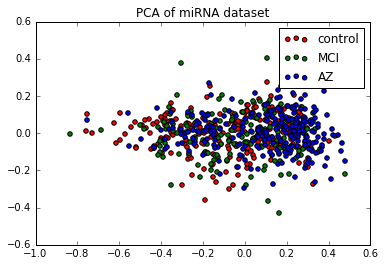

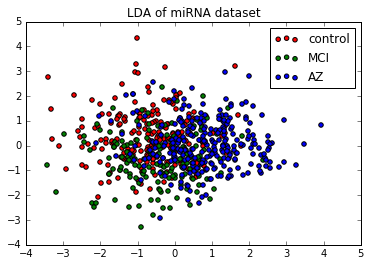

In [11]:
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

fig = plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title('PCA of miRNA dataset')
fig.savefig('DNA_methylation_PCA.jpg', bbox_inches='tight')

fig = plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title('LDA of miRNA dataset')
fig.savefig('DNA_methylation_LDA.jpg', bbox_inches='tight')

plt.show()

# 2. Lets do some predictions 

## 2.1 Set up crossvaliation and test set 

In [12]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, auc

# set labels
labels = mwasclin['cogdx'].values.tolist()
bin_labels = [1 if x == 4 else 0 for x in labels]

# set train set and test set
(X_train, X_test, y_train, y_test) = train_test_split(mwas.T,bin_labels,test_size=0.2,stratify=labels,random_state=0)

# set 5X crossvalidation within train set
slo = StratifiedShuffleSplit(y_train, n_iter=5, test_size=0.2, random_state=0)


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.lda import LDA

/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


In [14]:
params = [{'solver': ['newton-cg','lbfgs','liblinear','sag']}]
lr = GridSearchCV(LogisticRegression(), params, cv=slo, scoring='roc_auc')
lr.fit(X_train, y_train)
lr = lr.best_estimator_
print("Logistic Regression accuracy = {}".format(lr.score(X_test,y_test)))

Logistic Regression accuracy = 0.69465648855


/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [15]:
lr.solver

'liblinear'

In [16]:
lr_score = lr.decision_function(X_test)

In [17]:
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test,lr_score)
lr_roc_auc = auc(lr_fpr, lr_tpr)
lr_roc_auc

0.73463957426221582

In [18]:
params = [{'solver': ['svd','lsqr','eigen']}]
lda = GridSearchCV(LDA(), params, cv=slo, scoring='roc_auc')
lda.fit(X_train, y_train)
lda = lda.best_estimator_
print("LDA accuracy = {}".format(lda.score(X_test,y_test)))

LDA accuracy = 0.648854961832


In [19]:
lda.solver

'svd'

In [20]:
lda_score = lda.decision_function(X_test)

In [21]:
lda_fpr, lda_tpr, lda_thresholds = roc_curve(y_test,lda_score)
lda_roc_auc = auc(lda_fpr, lda_tpr)
lda_roc_auc

0.67174649250120955

In [22]:
params = [{'l1_ratio': [0,0.25,0.5,0.75,1], 'alpha': [0.01,0.1,1,10,100,1000]}]
el = GridSearchCV(ElasticNet(), params, cv = slo, scoring='roc_auc')
el.fit(X_train, y_train)
el = el.best_estimator_
print("Elastic Net accuracy = {}".format(el.score(X_test,y_test)))

Elastic Net accuracy = 0.129991300194


/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:454: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [23]:
el_score = el.decision_function(X_test)

/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function decision_function is deprecated;  and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


In [24]:
el_fpr, el_tpr, el_thresholds = roc_curve(y_test,el_score)
el_roc_auc = auc(el_fpr, el_tpr)
el_roc_auc

0.71698113207547176

In [25]:
params = [{'n_estimators': [10,50,100,200,300,400,500,1000]}]
rf = GridSearchCV(RandomForestClassifier(), params, cv =slo, scoring='roc_auc')
rf.fit(X_train, y_train)
rf = rf.best_estimator_
print("Random Forest accuracy = {}".format(rf.score(X_test,y_test)))

Random Forest accuracy = 0.702290076336


In [26]:
rf.n_estimators

500

In [27]:
rf_score = rf.predict_proba(X_test)

In [28]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test,rf_score[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)
rf_roc_auc

0.71383647798742145

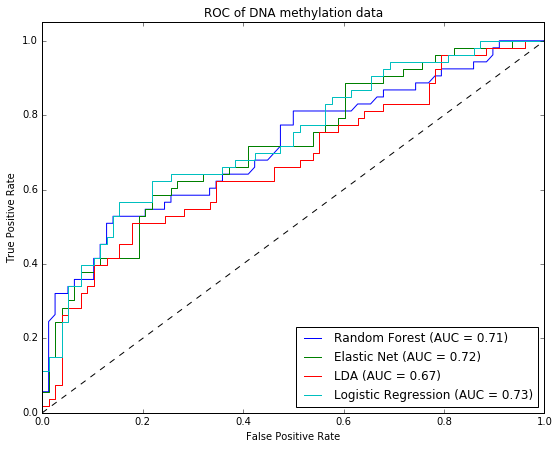

In [29]:
# Plot ROC curve
fig = plt.figure(1, figsize=(9, 7))
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = %0.2f)' % rf_roc_auc)
plt.plot(el_fpr, el_tpr, label='Elastic Net (AUC = %0.2f)' % el_roc_auc)
plt.plot(lda_fpr, lda_tpr, label='LDA (AUC = %0.2f)' % lda_roc_auc)
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (AUC = %0.2f)' % lr_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of DNA methylation data')
plt.legend(loc="lower right")

fig.savefig('DNAmeth_DEG.ROC.jpg', bbox_inches='tight')
plt.show()